# Imports

# Notes
**Player**
There are 4 players in this data set

Player 0: LLM
Player 1: In Game AI
Player 2: In Game AI
Player 3: In Game AI

Overall game outcome:
Player 2 wins the game

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import sqlite3
from scipy import stats
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
BASE_DIR = os.getcwd()


# Convert DB to CSV, store file name as key for later

In [4]:
# Folder where all CSVs live

output_dir = os.path.join(BASE_DIR, "data", "csv_exports")

files = glob.glob(os.path.join(output_dir, "*.csv"))

dfs = {}

for file in files:
    key = os.path.basename(file)        
    dfs[key] = pd.read_csv(file)
    print(f"Loaded {key} ({len(dfs[key])} rows)")

keys = list(dfs.keys())

print("\nKeys in dfs:")
print(keys)

for key in keys:
    print(f"\n---- {key} ----")
    print(dfs[key].head(), "\n")
    dfs[key].info()

print("\n")

Loaded GameMetadata.csv (19 rows)
Loaded StrategyChanges.csv (880 rows)
Loaded PlayerSummaries.csv (5356 rows)
Loaded PolicyChanges.csv (60 rows)
Loaded TacticalZones.csv (5588 rows)
Loaded sqlite_sequence.csv (12 rows)
Loaded PlayerOpinions.csv (1062 rows)
Loaded CityInformations.csv (12040 rows)
Loaded VictoryProgress.csv (241 rows)
Loaded PlayerOptions.csv (1367 rows)
Loaded ResearchChanges.csv (87 rows)
Loaded PlayerInformations.csv (13 rows)
Loaded GameEvents.csv (163465 rows)
Loaded PersonaChanges.csv (40 rows)

Keys in dfs:
['GameMetadata.csv', 'StrategyChanges.csv', 'PlayerSummaries.csv', 'PolicyChanges.csv', 'TacticalZones.csv', 'sqlite_sequence.csv', 'PlayerOpinions.csv', 'CityInformations.csv', 'VictoryProgress.csv', 'PlayerOptions.csv', 'ResearchChanges.csv', 'PlayerInformations.csv', 'GameEvents.csv', 'PersonaChanges.csv']

---- GameMetadata.csv ----
         Key                                 Value
0     gameId  02b369b7-c039-4c04-8221-09bd8871b5df
1   lastSync          

# Initial EDA

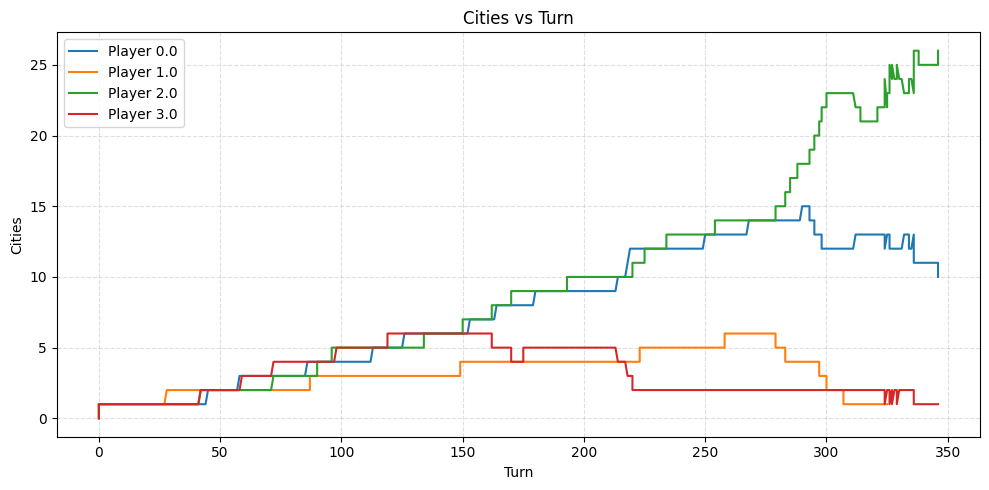

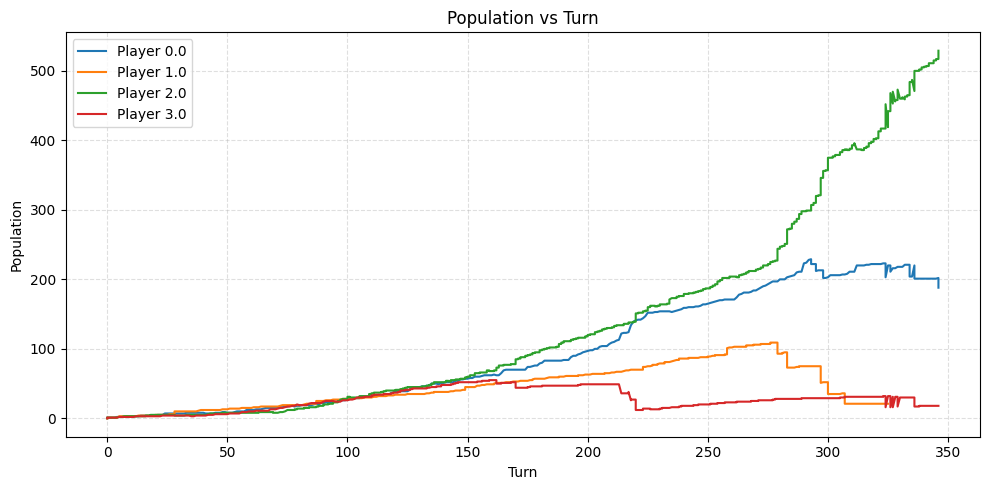

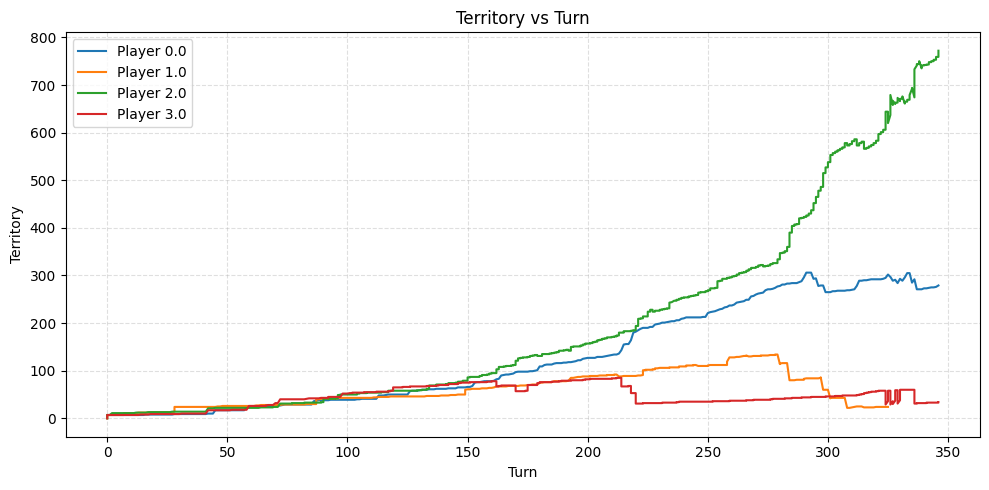

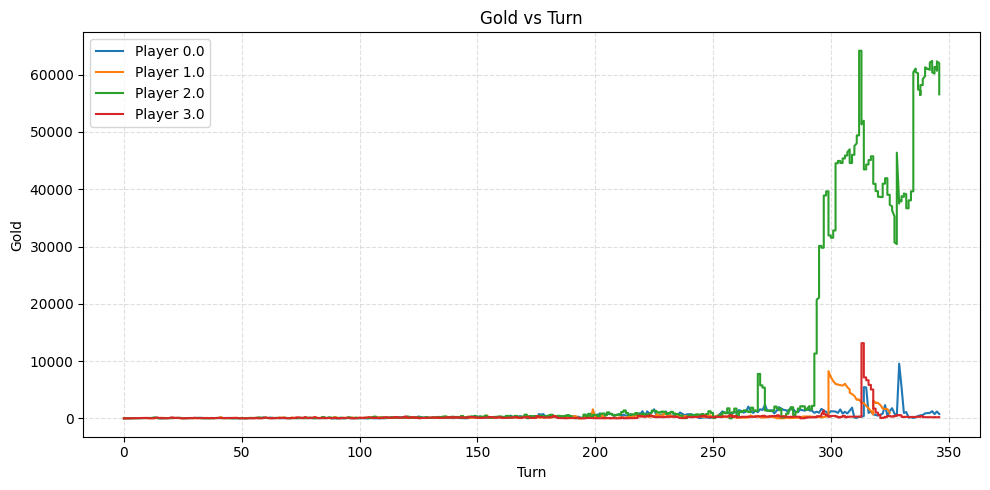

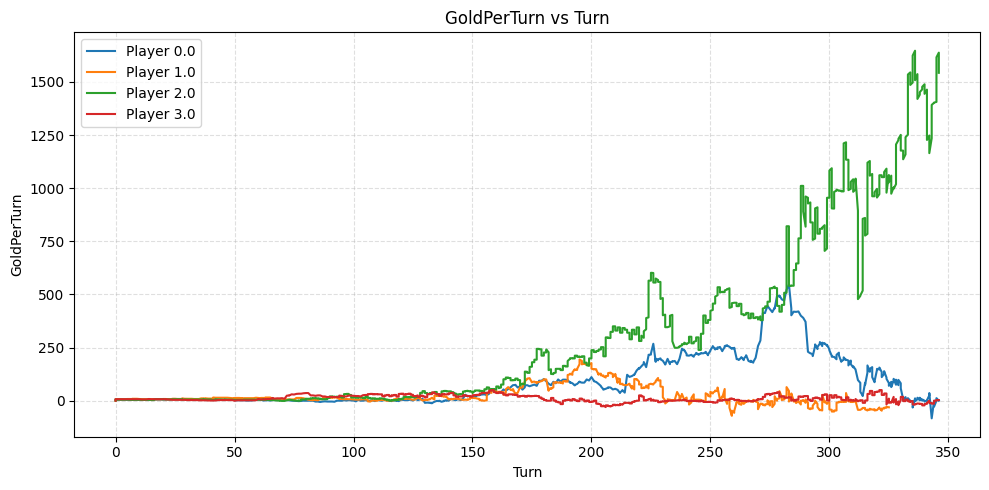

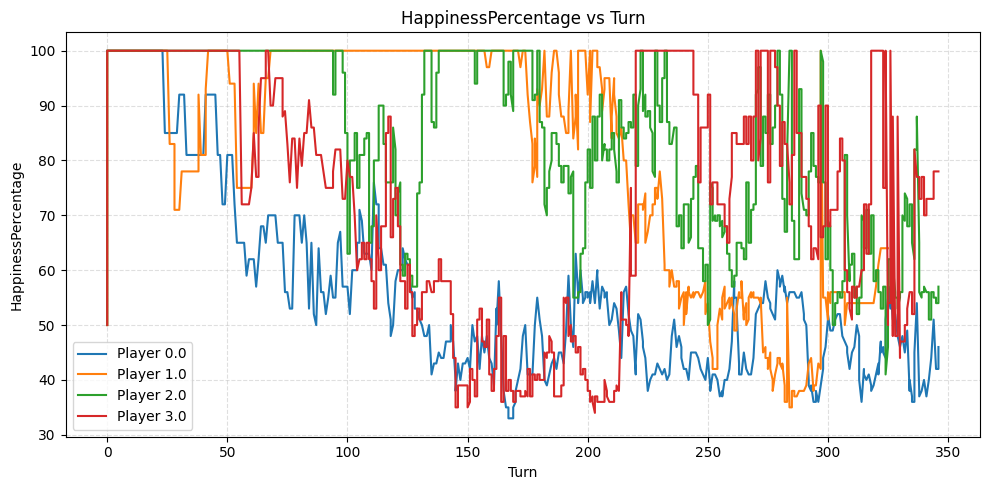

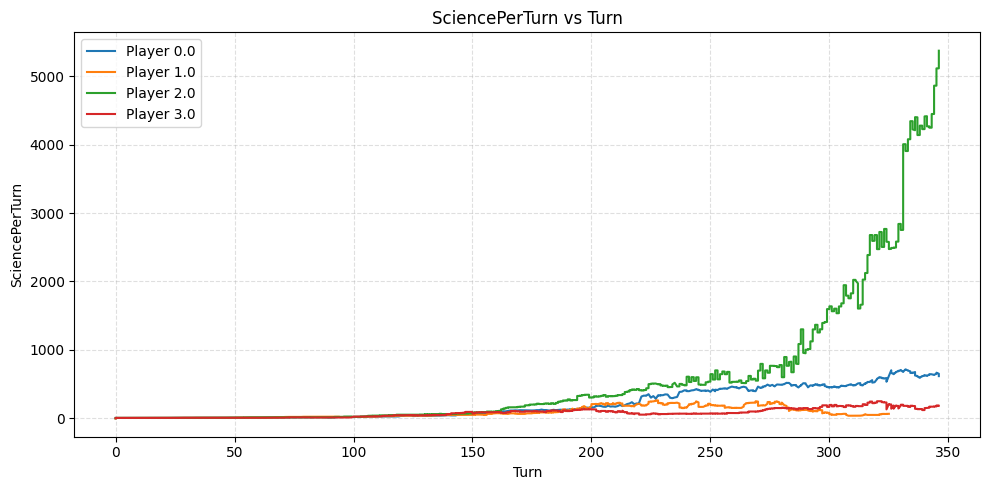

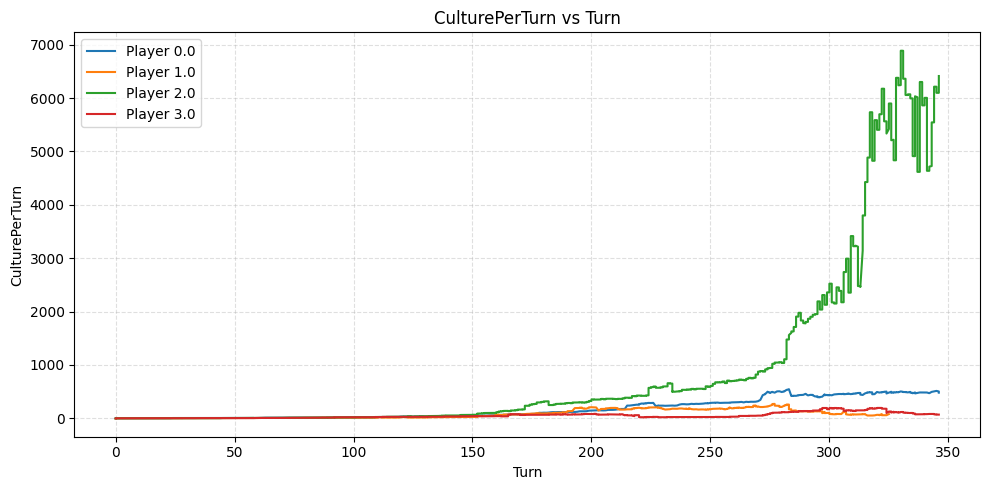

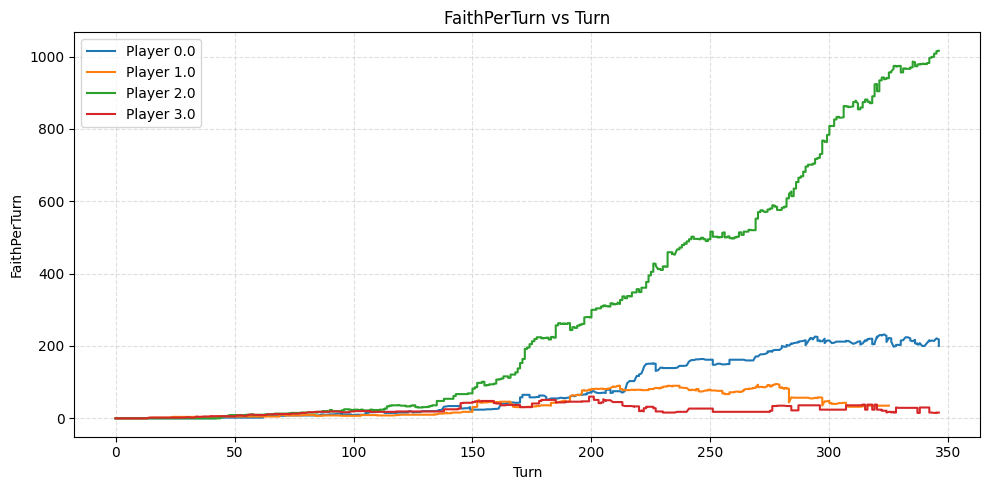

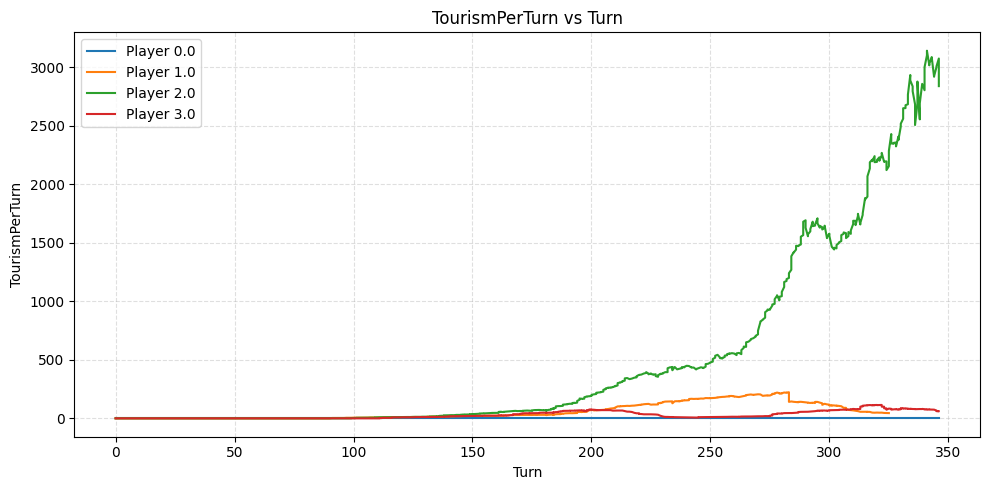

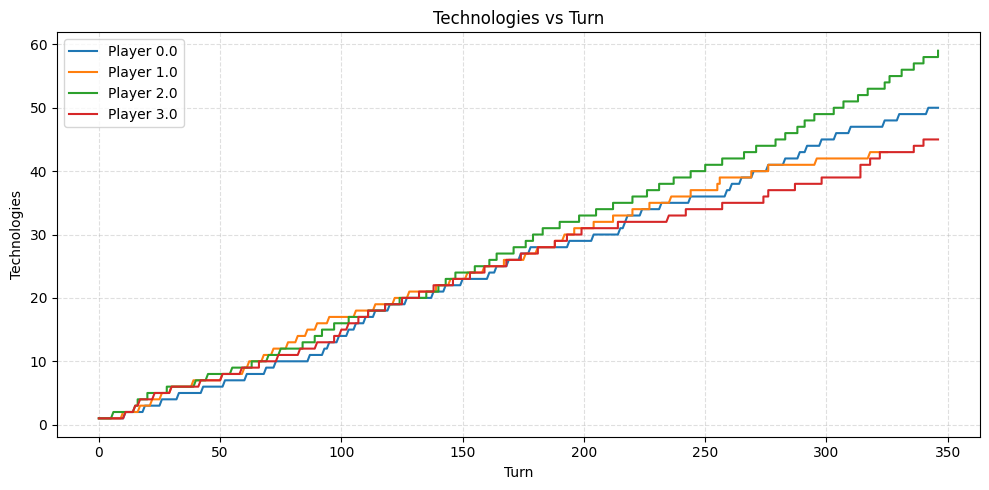

In [ ]:

# load data
df_playerSummaries = dfs["PlayerSummaries.csv"].copy()
df_cityInformation = dfs["CityInformations.csv"].copy()


# get players

player_cols = [f"Player{i}" for i in range(6)]

def determine_active_player(row):
    for i, col in enumerate(player_cols):
        if row[col] == 2:
            return i
    return None

df_playerSummaries["ActivePlayer"] = df_playerSummaries.apply(determine_active_player, axis=1)

# Only 4 players
df_playerSummaries = df_playerSummaries[df_playerSummaries["ActivePlayer"].isin([0, 1, 2, 3])]


# initial EDA on specific metrics vs turn

metrics = [
    "Cities", "Population", "Territory",
    "Gold", "GoldPerTurn",
    "HappinessPercentage",
    "SciencePerTurn", "CulturePerTurn",
    "FaithPerTurn", "TourismPerTurn",
    "Technologies"
]

# Ensure numeric
for m in metrics:
    df_playerSummaries[m] = pd.to_numeric(df_playerSummaries[m], errors="coerce")

def plot_metric(df, metric, use_scatter=False):
    plt.figure(figsize=(10, 5))
    
    for player in sorted(df["ActivePlayer"].unique()):
        sub = df[df["ActivePlayer"] == player]
        x = sub["Turn"]
        y = sub[metric]

        if use_scatter:
            plt.scatter(x, y, s=10, alpha=0.7, label=f"Player {player}")
        else:
            plt.plot(x, y, label=f"Player {player}")
    
    plt.title(f"{metric} vs Turn")
    plt.xlabel("Turn")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

for metric in metrics:
    plot_metric(df_playerSummaries, metric, use_scatter=False)

# Heatmap Correlations

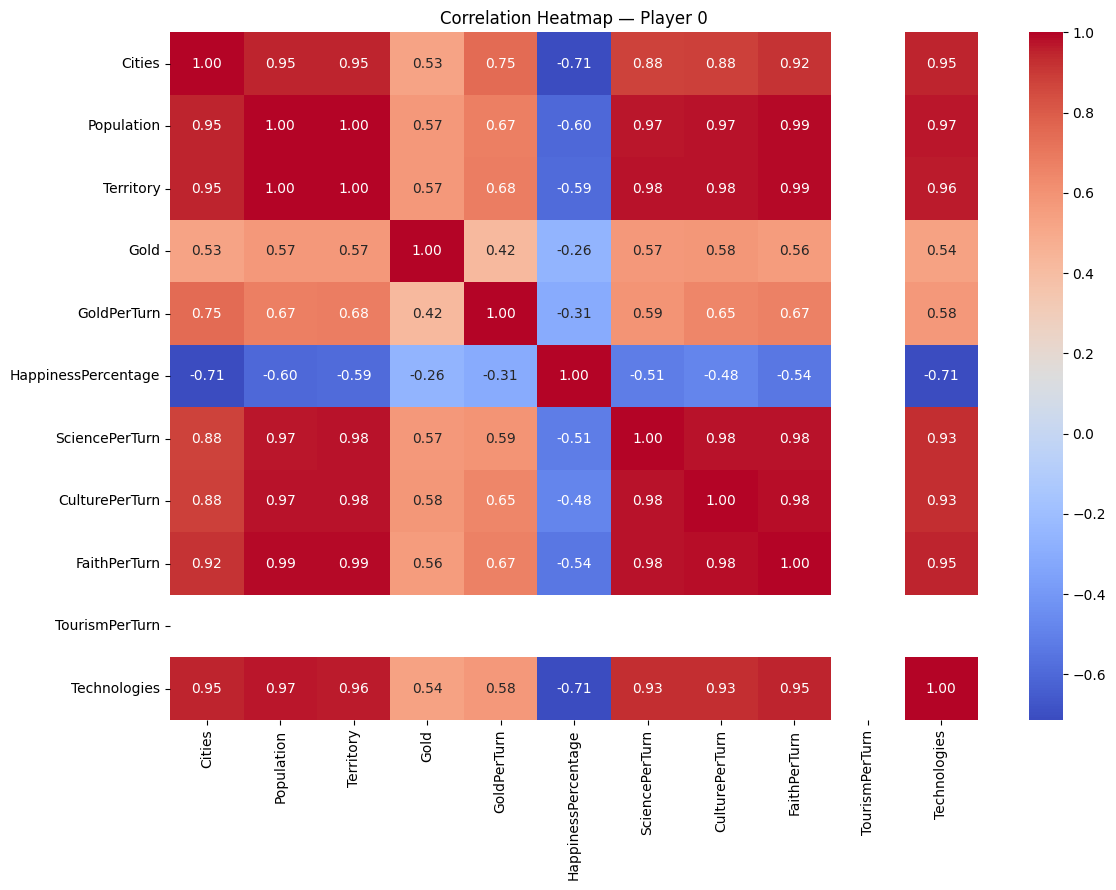

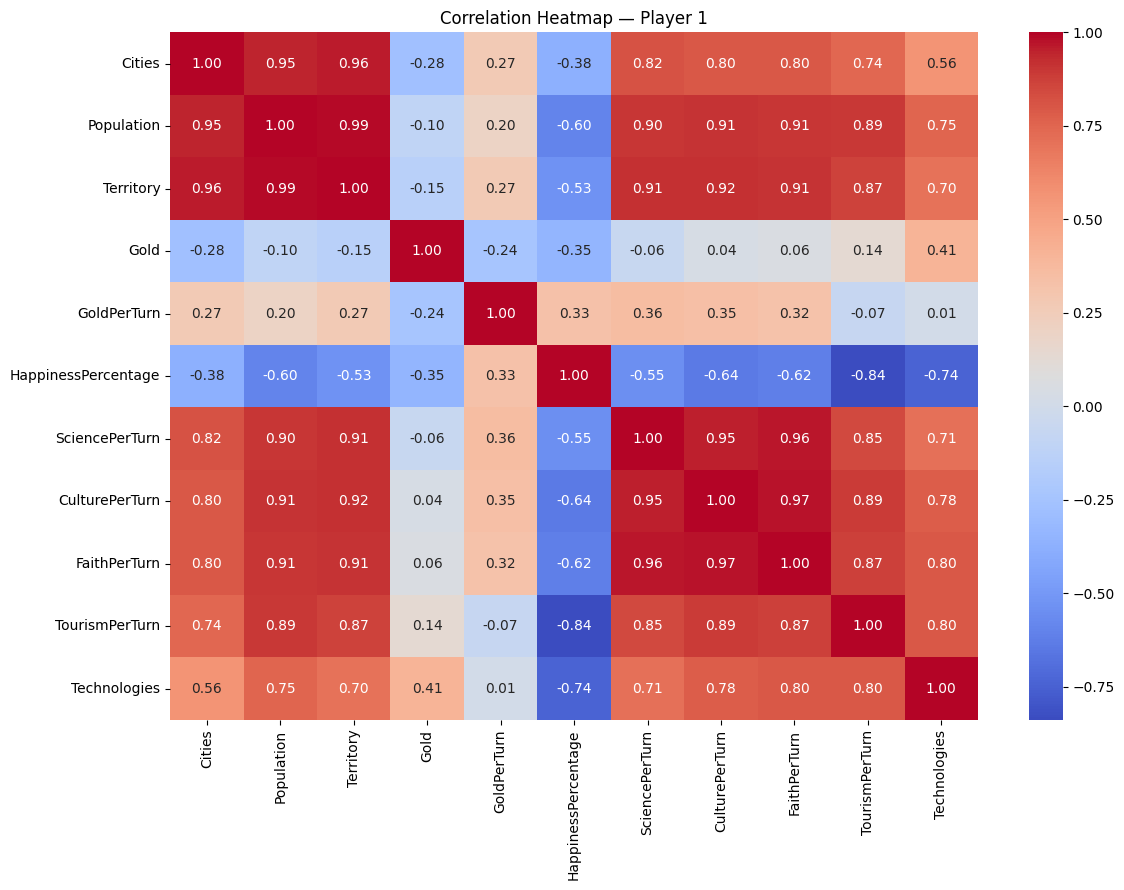

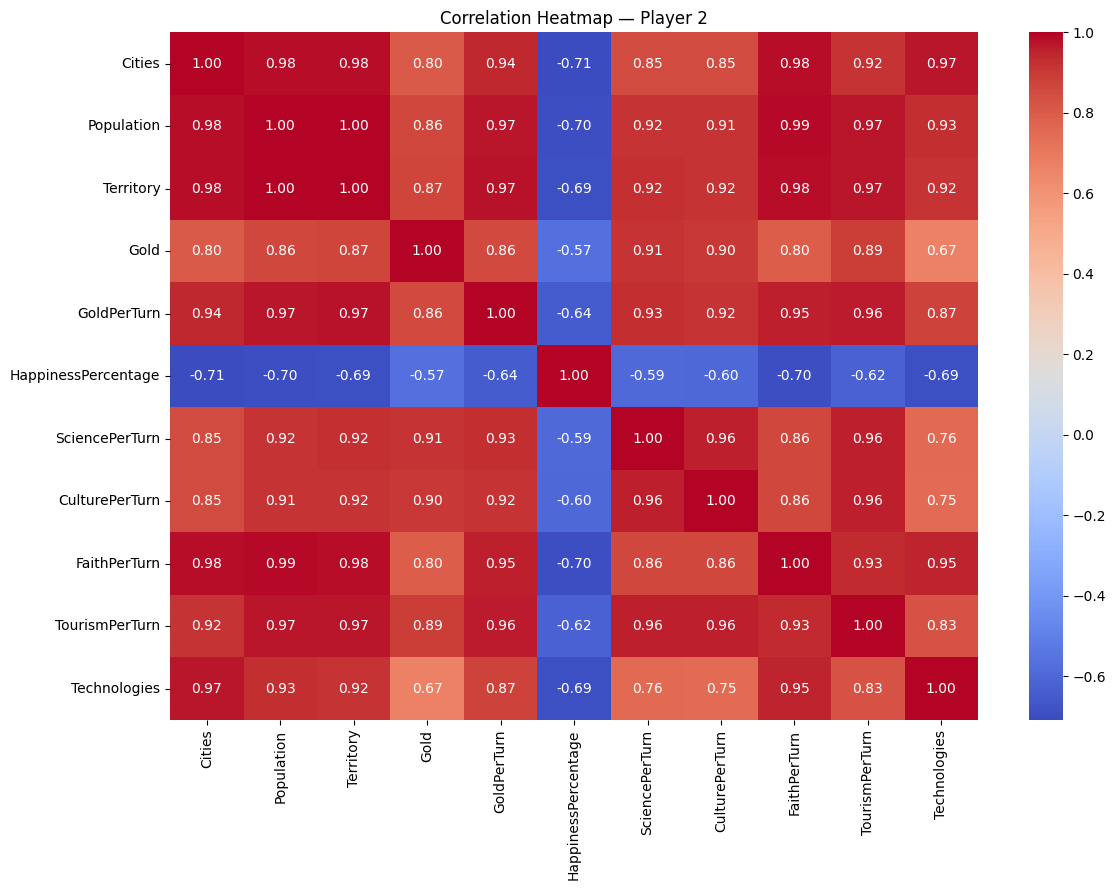

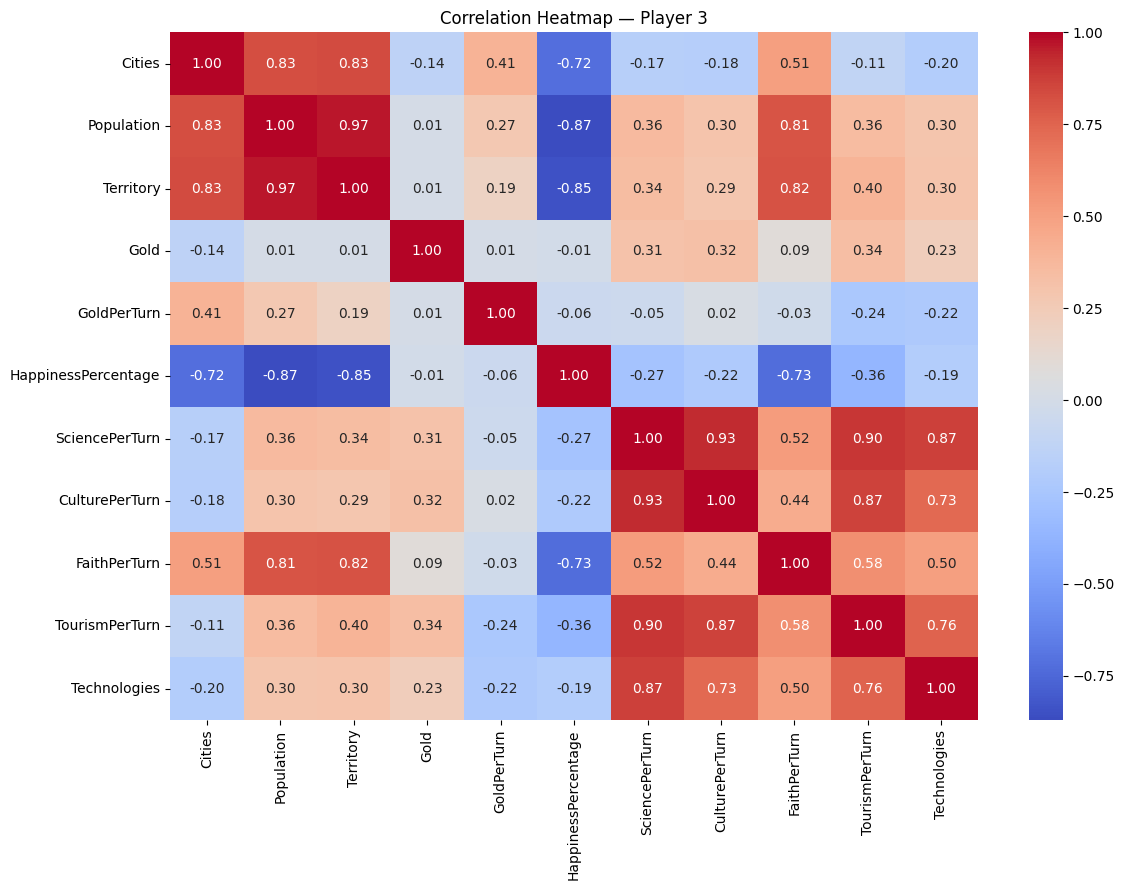

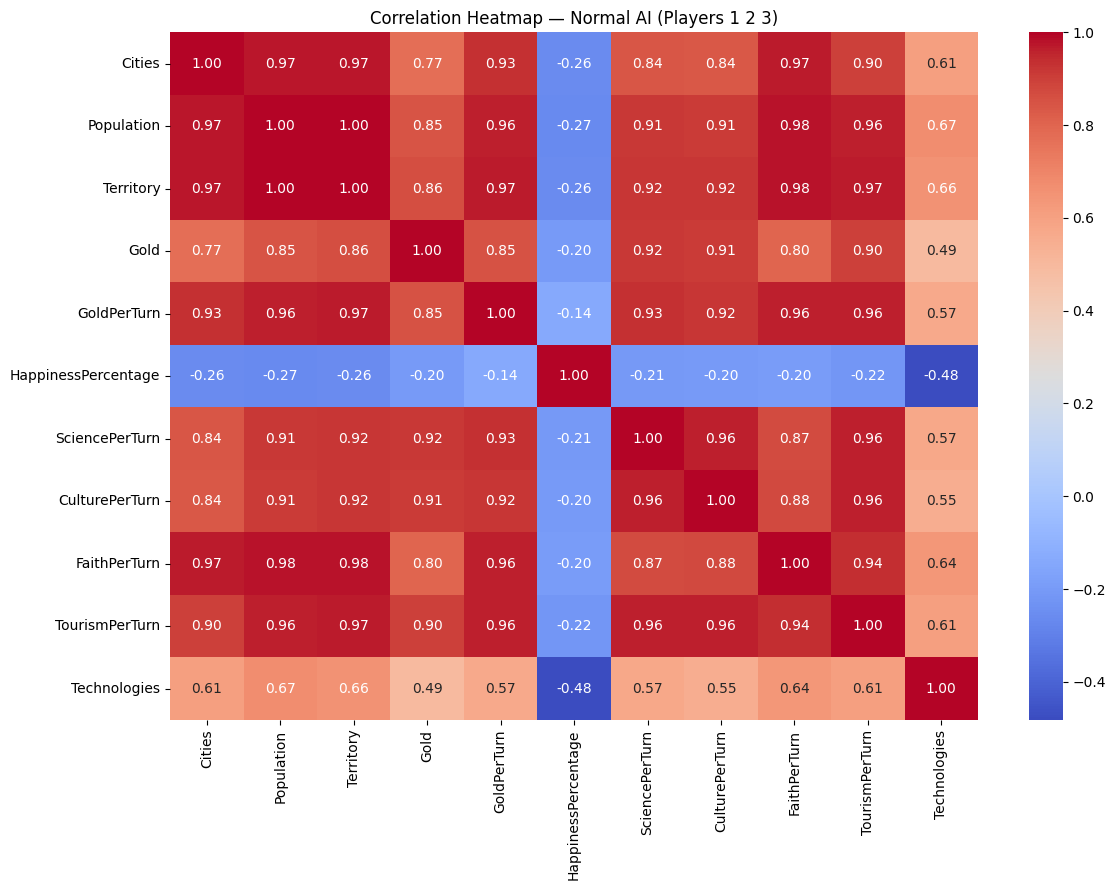

['The Ottomans' 'Venice' 'Indonesia' 'Korea' 'City-States']


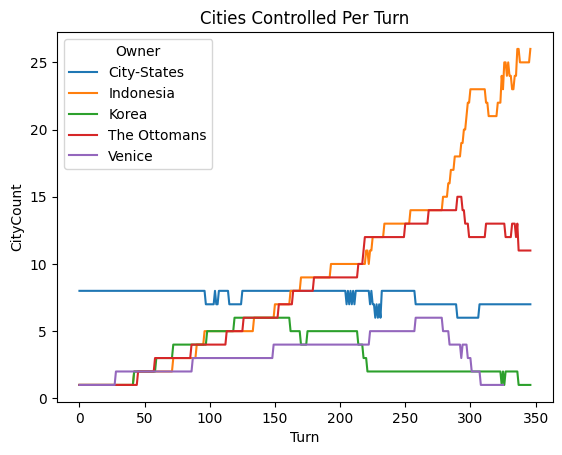

Owner  City-States  Indonesia  Korea  The Ottomans  Venice
Turn                                                      
0              8.0        1.0    1.0           1.0     1.0
1              8.0        1.0    1.0           1.0     1.0
2              8.0        1.0    1.0           1.0     1.0
3              8.0        1.0    1.0           1.0     1.0
4              8.0        1.0    1.0           1.0     1.0
...            ...        ...    ...           ...     ...
342            7.0       25.0    1.0          11.0     NaN
343            7.0       25.0    1.0          11.0     NaN
344            7.0       25.0    1.0          11.0     NaN
345            7.0       25.0    1.0          11.0     NaN
346            7.0       26.0    1.0          11.0     NaN

[347 rows x 5 columns]
[0 1 2 3]
Detected valid players: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


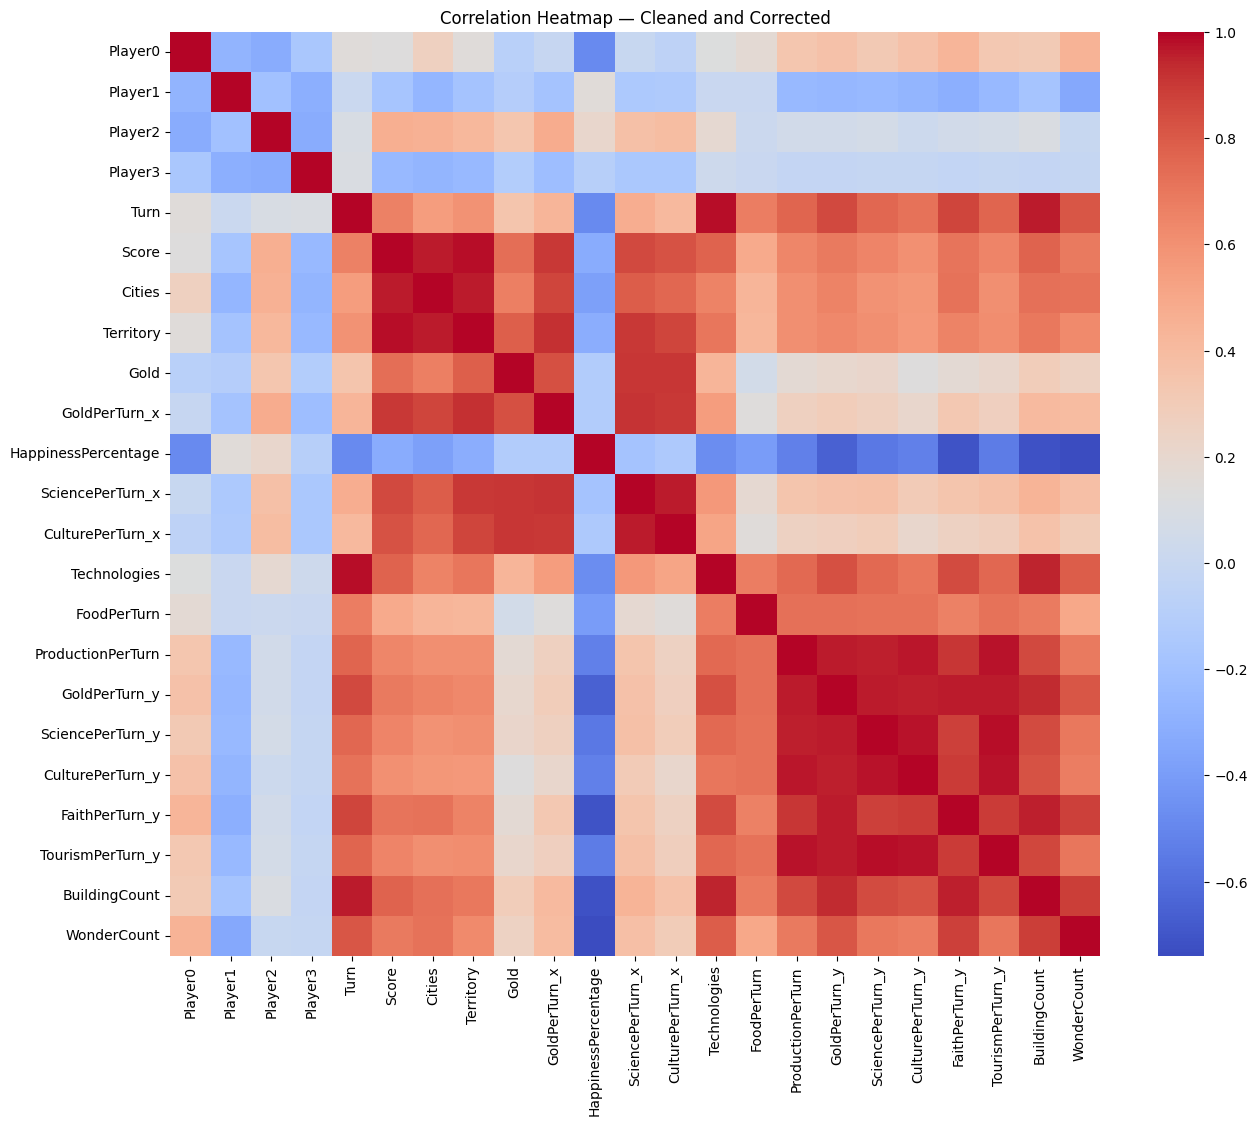

In [ ]:
df = df_playerSummaries


def plot_heatmap(data, title):
    corr = data.corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Build per-player heatmaps
players = [0, 1, 2, 3]

for p in players:
    df_p = df_playerSummaries[df_playerSummaries["ActivePlayer"] == p][metrics].dropna()
    plot_heatmap(df_p, f"Correlation Heatmap — Player {p}")

# Separate group heatmap: Players 2–4 (Normal AI)
df_normal_ai = df_playerSummaries[df_playerSummaries["ActivePlayer"].isin([1,2,3])][metrics].dropna()
plot_heatmap(df_normal_ai, "Correlation Heatmap — Normal AI (Players 1 2 3)")


##Analyze CityInformation.csv

#plot city size by player per turn


city_df = pd.read_csv("data/csv_exports/CityInformations.csv")

city_df["Turn"] = pd.to_numeric(city_df["Turn"], errors="coerce")
city_unique = city_df.drop_duplicates(subset=["Turn", "Name", "Owner"])

print(city_df["Owner"].unique()[:20])

# Cities per player per turn
cities_per_turn = (
    city_unique.groupby(["Turn", "Owner"])
               .size()
               .reset_index(name="CityCount")
)


sns.lineplot(data=cities_per_turn, x="Turn", y="CityCount", hue="Owner")
plt.title("Cities Controlled Per Turn")
plt.show()

city_pivot = cities_per_turn.pivot(index="Turn", columns="Owner", values="CityCount")
print(city_pivot)

# Debug prints
# print(city_df.columns)
# strat_df = pd.read_csv("csv_exports/StrategyChanges.csv")
# print("\n")
# print(strat_df.columns)

## Analysis on city economics to player economics
# Average city yields per player per turn
player_cols = [f"Player{i}" for i in range(22)]  # Player0..Player21

def get_active_player(row):
    for i, col in enumerate(player_cols):
        if row[col] == 2:        # 2 = it's that player's turn
            return i
    return None

df_playerSummaries["ActivePlayer"] = df_playerSummaries.apply(get_active_player, axis=1)
print(df_playerSummaries["ActivePlayer"].unique())

city_player_cols = [f"Player{i}" for i in range(22)]

def get_city_owner(row):
    for i, col in enumerate(city_player_cols):
        if row[col] == 1:      # 1 = city is owned by this player
            return i
    return None

city_df["OwnerID"] = city_df.apply(get_city_owner, axis=1)
city_yields = (
    city_df
    .groupby(["Turn", "OwnerID"])[[
        "Population", "FoodPerTurn", "ProductionPerTurn",
        "GoldPerTurn", "SciencePerTurn", "CulturePerTurn",
        "FaithPerTurn", "TourismPerTurn",
        "BuildingCount", "WonderCount"
    ]]
    .mean()
    .reset_index()
)
df_playerSummaries["ActivePlayer"] = df_playerSummaries["ActivePlayer"].astype(int)
city_yields["OwnerID"] = city_yields["OwnerID"].astype(int)
df_playerSummaries["Turn"] = df_playerSummaries["Turn"].astype(int)
city_yields["Turn"] = city_yields["Turn"].astype(int)



merged = pd.merge(
    df_playerSummaries,
    city_yields,
    left_on=["Turn", "ActivePlayer"],
    right_on=["Turn", "OwnerID"],
    how="left"
)


# Detect players that appear in the match
valid_players = sorted(df_playerSummaries["ActivePlayer"].dropna().unique())

print("Detected valid players:", valid_players)

# Filter to only valid players
df_filtered = merged[merged["ActivePlayer"].isin(valid_players)].copy()

# Drop unused Player columns
cols_to_drop = [
    c for c in df_filtered.columns 
    if c.startswith("Player") and int(c.replace("Player","")) not in valid_players
]
df_filtered = df_filtered.drop(columns=cols_to_drop)

# Build heatmap
# Clean numeric columns to include only meaningful gameplay features
keep_cols = [
    # index
    "Player0","Player1","Player2","Player3","Turn",

    # player-level (from PlayerSummaries)
    "Score", "Cities", "Population", "Territory",
    "Gold", "GoldPerTurn_x", "HappinessPercentage",
    "SciencePerTurn_x", "CulturePerTurn_x", "FaithPerTurn",
    "TourismPerTurn", "Technologies",

    # city-level (from city_yields)
    "FoodPerTurn", "ProductionPerTurn", "GoldPerTurn_y",
    "SciencePerTurn_y", "CulturePerTurn_y", "FaithPerTurn_y",
    "TourismPerTurn_y", "BuildingCount", "WonderCount",
]

# Build heatmap from df_filtered, NOT merged
df_corr = df_filtered[[c for c in keep_cols if c in df_filtered.columns]].copy()

# Generate correlation matrix
corr = df_corr.select_dtypes("number").corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap All Players")
plt.show()

# Clustering and Dendrogram
**Includes a clustering plot showing change in strategy by turn**

Combined per-turn data: (1367, 18)
   Turn  Cities  Population_x  Territory  GoldPerTurn_x  SciencePerTurn_x  \
0     0     1.0           1.0        7.0            5.0               6.0   
1     1     1.0           1.0        7.0            5.0               6.0   
2     2     1.0           1.0        7.0            5.0               6.0   
3     3     1.0           1.0        7.0            5.0               6.0   
4     4     1.0           2.0        7.0            5.0               6.0   

   CulturePerTurn_x  FaithPerTurn_x  FoodPerTurn  ProductionPerTurn  \
0               1.0             0.0          0.0                0.0   
1               1.0             0.0          0.0                0.0   
2               1.0             0.0          0.0                0.0   
3               1.0             0.0          0.0                0.0   
4               1.0             0.0          0.0                0.0   

   GoldPerTurn_y  SciencePerTurn_y  CulturePerTurn_y  FaithPerTurn_y  \
0  

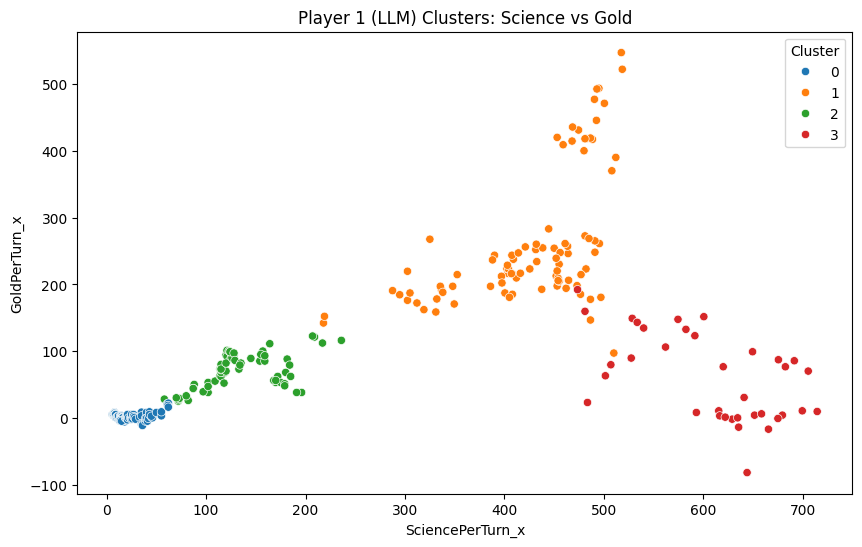

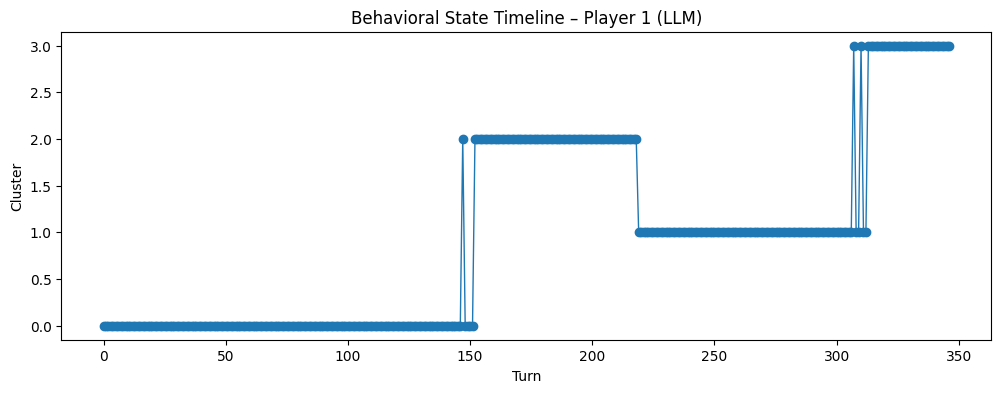

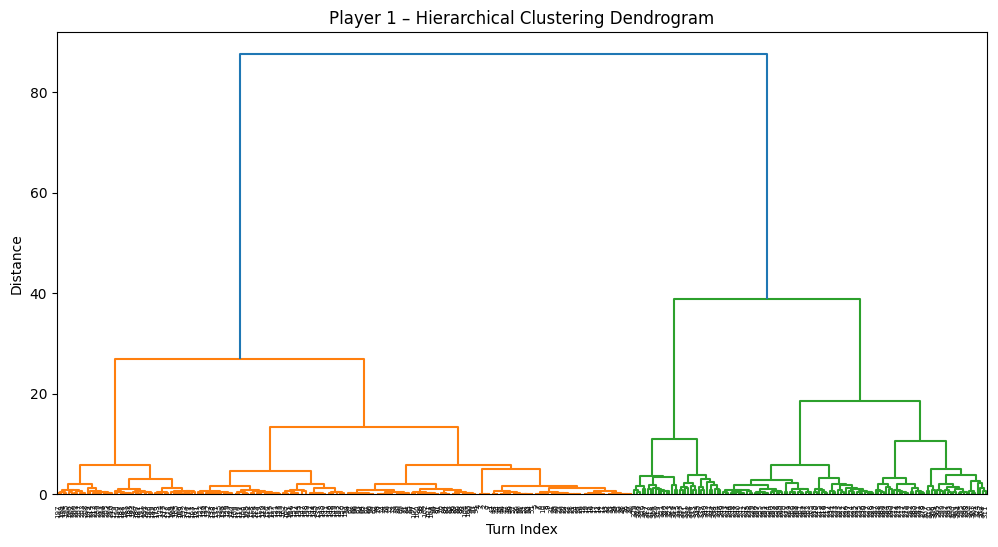

cluster centroid

     Cities  Population_x  Territory  GoldPerTurn_x  SciencePerTurn_x  \
0 -1.012305     -0.951070  -0.942342      -0.728947         -0.874430   
1  1.153108      1.087720   1.092531       1.417746          0.984381   
2  0.164270     -0.148480  -0.182334      -0.166049         -0.352218   
3  0.988939      1.489942   1.504985      -0.251954          1.817410   

   CulturePerTurn_x  FaithPerTurn_x  FoodPerTurn  ProductionPerTurn  \
0         -0.867356       -0.901290    -0.732419          -0.706390   
1          0.995506        1.097563     0.384578           0.486038   
2         -0.325332       -0.315386    -0.067201          -0.339840   
3          1.708522        1.571257     2.216217           2.362734   

   GoldPerTurn_y  SciencePerTurn_y  CulturePerTurn_y  FaithPerTurn_y  \
0      -0.836094         -0.681303         -0.697844       -0.965084   
1       0.619735          0.318419          0.373463        0.912308   
2      -0.167072         -0.234704         -

In [7]:
metrics = [
    # Player-level yields (PlayerSummaries → _x)
    "Cities",
    "Population_x",
    "Territory",
    "GoldPerTurn_x",
    "SciencePerTurn_x",
    "CulturePerTurn_x",
    "FaithPerTurn_x",

    # Removed (always 0)
    # "TourismPerTurn_x",

    # City-level yields (CityInfo → _y)
    "FoodPerTurn",
    "ProductionPerTurn",
    "GoldPerTurn_y",
    "SciencePerTurn_y",
    "CulturePerTurn_y",
    "FaithPerTurn_y",
    "TourismPerTurn_y",
    "BuildingCount",
    "WonderCount",
]


# FUNCTION: Build one-row-per-turn table for a single player

def build_player_turn_table(player_id, merged, metrics):
    """Returns clean 1-row-per-turn summary for one player."""

    # Select rows for this player
    df_p = merged[merged["ActivePlayer"] == player_id].copy()

    # Keep only metrics that actually exist
    existing = [m for m in metrics if m in df_p.columns]

    # Group to ONE ROW per turn (averaging multiple city rows)
    df_turn = (
        df_p.groupby("Turn")[existing]
        .mean()
        .reset_index()
    )

    # Add Player label
    df_turn["Player"] = player_id
    
    df_turn = df_turn.fillna(0)

    return df_turn


# Build tables for all players (0–3)

player_tables = []
for p in [0, 1, 2, 3]:
    df_player = build_player_turn_table(p, merged, metrics)
    player_tables.append(df_player)

df_all_players = pd.concat(player_tables, ignore_index=True)

print("Combined per-turn data:", df_all_players.shape)
print(df_all_players.head())


# CLUSTERING PER PLAYER

def cluster_player(df_player, metrics, k=4):
    """Run KMeans clustering on one player's turn-level summary."""

    X = df_player[metrics].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    df_player["Cluster"] = kmeans.fit_predict(X_scaled)

    return df_player, kmeans, X_scaled



# Run clustering for Player 0 (LLM)
# 0 indexing, player 1 == 0

df_p1 = df_all_players[df_all_players["Player"] == 0].copy()
df_p1, kmeans_p1, X_scaled_p1 = cluster_player(df_p1, metrics, k=4)



# SCATTER PLOT: Science vs Gold (Cluster Colors)
# Expand to other relevant 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_p1,
    x="SciencePerTurn_x",
    y="GoldPerTurn_x",
    hue="Cluster",
    palette="tab10"
)
plt.title("Player 1 (LLM) Clusters: Science vs Gold")
plt.show()


# BEHAVIORAL TIMELINE

plt.figure(figsize=(12, 4))
plt.plot(df_p1["Turn"], df_p1["Cluster"], marker="o", linewidth=1)
plt.title("Behavioral State Timeline – Player 1 (LLM)")
plt.xlabel("Turn")
plt.ylabel("Cluster")
plt.show()


# HIERARCHICAL DENDROGRAM 

Z = linkage(X_scaled_p1, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title("Player 1 – Hierarchical Clustering Dendrogram")
plt.xlabel("Turn Index")
plt.ylabel("Distance")
plt.show()

print("cluster centroid\n")
centroids = kmeans_p1.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=metrics)
print(centroids_df)



# DISPLAY CENTROID TABLE 

print("\n=== Cluster Centroids (Scaled Space) ===")
print(centroids_df.round(3))



# NORMALIZE CENTROIDS FOR RADAR CHART VISUALIZATION

# Radar charts look best when all values scaled 0–1
centroids_norm = (centroids_df - centroids_df.min()) / (centroids_df.max() - centroids_df.min())

# categories for radar chart
categories = list(centroids_norm.columns)
N = len(categories)

# angle setup for radar
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # repeat first point to close the circle


#Radar Chart Based on Clustering

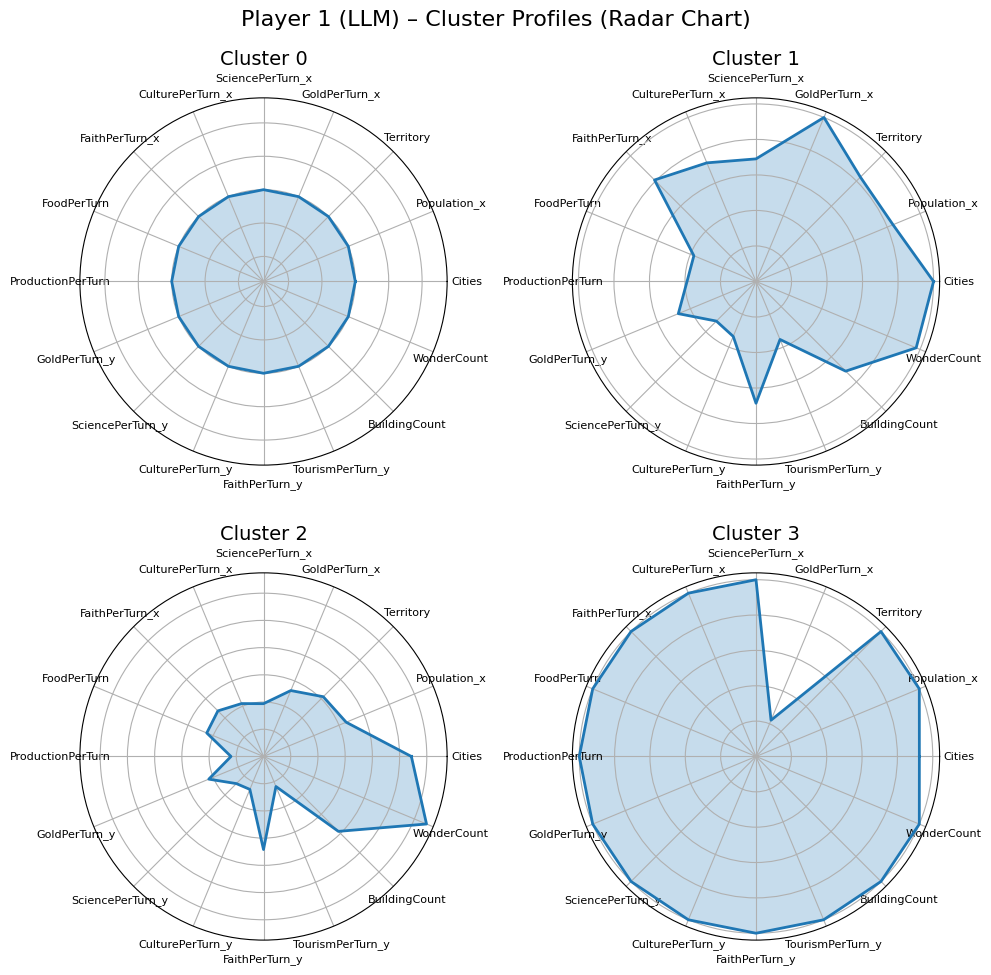

               GoldPerTurn_x  GoldPerTurn_y    Cities
GoldPerTurn_x       1.000000        0.44524  0.765051
GoldPerTurn_y       0.445240        1.00000  0.809600
Cities              0.765051        0.80960  1.000000


In [9]:
plt.figure(figsize=(10, 10))
plt.suptitle("Player 1 (LLM) – Cluster Profiles (Radar Chart)", fontsize=16)

for idx in range(len(centroids_norm)):
    values = centroids_norm.iloc[idx].tolist()
    values += values[:1]  
    
    ax = plt.subplot(2, 2, idx + 1, polar=True)
    ax.plot(angles, values, linewidth=2, label=f"Cluster {idx}")
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f"Cluster {idx}", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)
    ax.set_yticklabels([])  

plt.tight_layout()
plt.show()


print(df_p1[["GoldPerTurn_x", "GoldPerTurn_y", "Cities"]].corr())
